## Diffusion Model Recurrent

### 1 Import Stanford Cars Dataset

Place it under *Dataset* folder

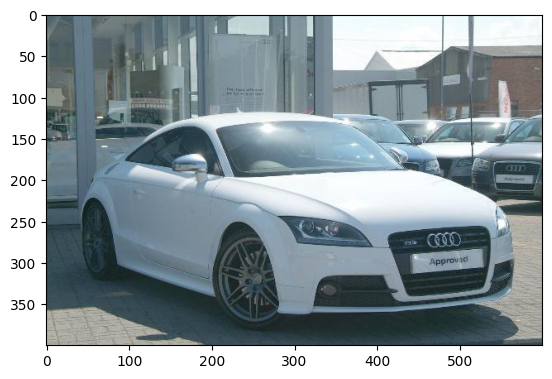

In [49]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader

device = torch.device ("cuda" if torch.cuda.is_available () else "cpu")

data = torchvision.datasets.StanfordCars (root = "./Dataset")
plt.imshow (data[0][0])

### 2 Forward Pass

#### 2.1 Preperations

- Generate simple linear beta schedule
- Compute formulas for further usage
    - `alphas_cumprod[k]` refers to $\bar{\alpha}_t = \prod\limits_{i = 0}^t \alpha_i$
    - `alphas_1_cumprod` refers to a new list $[1.0, \bar{\alpha}_0, \bar{\alpha}_1, \cdots]$, which will be used for $\bar{\beta}_t$ calculation (\bar{\alphas}_{t - 1})
    - `alphas_sqrt_reciprocal[t]` refers to $\sqrt{\frac{1}{\alpha_t}}$
    - `alphas_cumprod_sqrt[t]` refers to $\sqrt{\bar{\alpha}_t}$
    - `alphas_cumprod_sqrt_one_minus_which[t]` refers to $\sqrt{1 - \bar{\alpha}_t}$

In [28]:
T = 300
beta_start = 0.0001; beta_end = 0.02
betas = torch.linspace (beta_start, beta_end, T)

alphas = 1.0 - betas
alphas_cumprod = torch.cumprod (alphas, axis = 0)
alphas_1_cumprod = torch.cat ([torch.tensor ([1]), alphas_cumprod])[: - 1]
alphas_sqrt_reciprocal = torch.sqrt (1.00 / alphas)
alphas_cumprod_sqrt = torch.sqrt (alphas_cumprod)
alphas_cumprod_sqrt_one_minus_which = torch.sqrt (1 - alphas_cumprod)
posterior_variance = (1.0 - alphas_1_cumprod) / (1.0 - alphas_cumprod) * betas

#### 2.2 Load Data & Apply Forward Pass Operations

- Images will be resized to $(64, 64)$ and scaled to $[- 1, 1]$
- To show a tensor image, we need to transpose the dimensions of the tensor from CHW (Channel, Height, Width) to HWC (Height, Width, Channel). This is because in PyTorch, the channel is typically the first dimension in image data, while in PIL images, the channel is usually the last dimension

In [63]:
# Load Data

IMG_SIZE = 64
BATCH_SIZE = 128

def load_dataset ():
    data_transform = transforms.Compose ([
        transforms.Resize ([IMG_SIZE, IMG_SIZE]),
        transforms.RandomHorizontalFlip (),
        transforms.ToTensor (), # scale data into [0, 1]
        transforms.Lambda (lambda t: (t * 2.0) - 1.0)
    ])

    train = torchvision.datasets.StanfordCars (root = "./Dataset", transform = data_transform)
    test = torchvision.datasets.StanfordCars (root = "./Dataset", transform = data_transform, split = "test")

    return torch.utils.data.ConcatDataset ([train, test])

def show_tensor_image (image):
    image.to ("cpu")
    if (len (image.shape) == 4):
        image = image[0, :, :, :]

    reverse_transform = transforms.Compose ([
        transforms.Lambda (lambda t: 255.0 * ((t + 1.0) / 2.0)),
        transforms.Lambda (lambda t: t.permute (1, 2, 0)), # CHW to HWC
        transforms.Lambda (lambda t: t.numpy ().astype (np.uint8)),
        transforms.ToPILImage (),
    ])

    plt.imshow (reverse_transform (image))

data = load_dataset ()
data_loader = DataLoader (data, batch_size = BATCH_SIZE, shuffle = True, drop_last = True)

In the forward pass, we first sample a value from standard normal distribution $\mathcal{N} (0, 1)$, then compute the final result $q (x_t | x_0) = \mathcal{N} (x_t; \sqrt{\bar{\alpha}_t}x_0, (1 - \bar{\alpha}_t)\textbf{I})$ by transforming the standard distribution to the arbitrary one, i.e., $x_t = \sqrt{\bar{\alpha}_t}x_0 + \sqrt{1 - \bar{\alpha}_t}\varepsilon$

In [61]:
# Forward Pass

def get_value_by_index (a, ids, out_shape):
    batch_size = ids.shape[0]
    # find the value in the list according to indices
    ret  = a.gather (- 1, ids)
    # here for example the length of out_shape is 3, the reshaped value should be (batch_size, 1, 1)
    ret.reshape (batch_size, * ((1, ) * (len (out_shape) - 1)))

    return ret.to (device)

def diffusion_forward (x0, t):
    # randn_like returns a normal distribution in the same shape of x0
    noise = torch.randn_like (x0).to (device)
    alphas_cumprod_sqrt_t = get_value_by_index (alphas_cumprod_sqrt, t, x0).to (device)
    alphas_cumprod_sqrt_one_minus_which_t = get_value_by_index (alphas_cumprod_sqrt_one_minus_which, t, x0).to (device)

    return (alphas_cumprod_sqrt_t * x0.to (device) + alphas_cumprod_sqrt_one_minus_which_t * noise, noise)

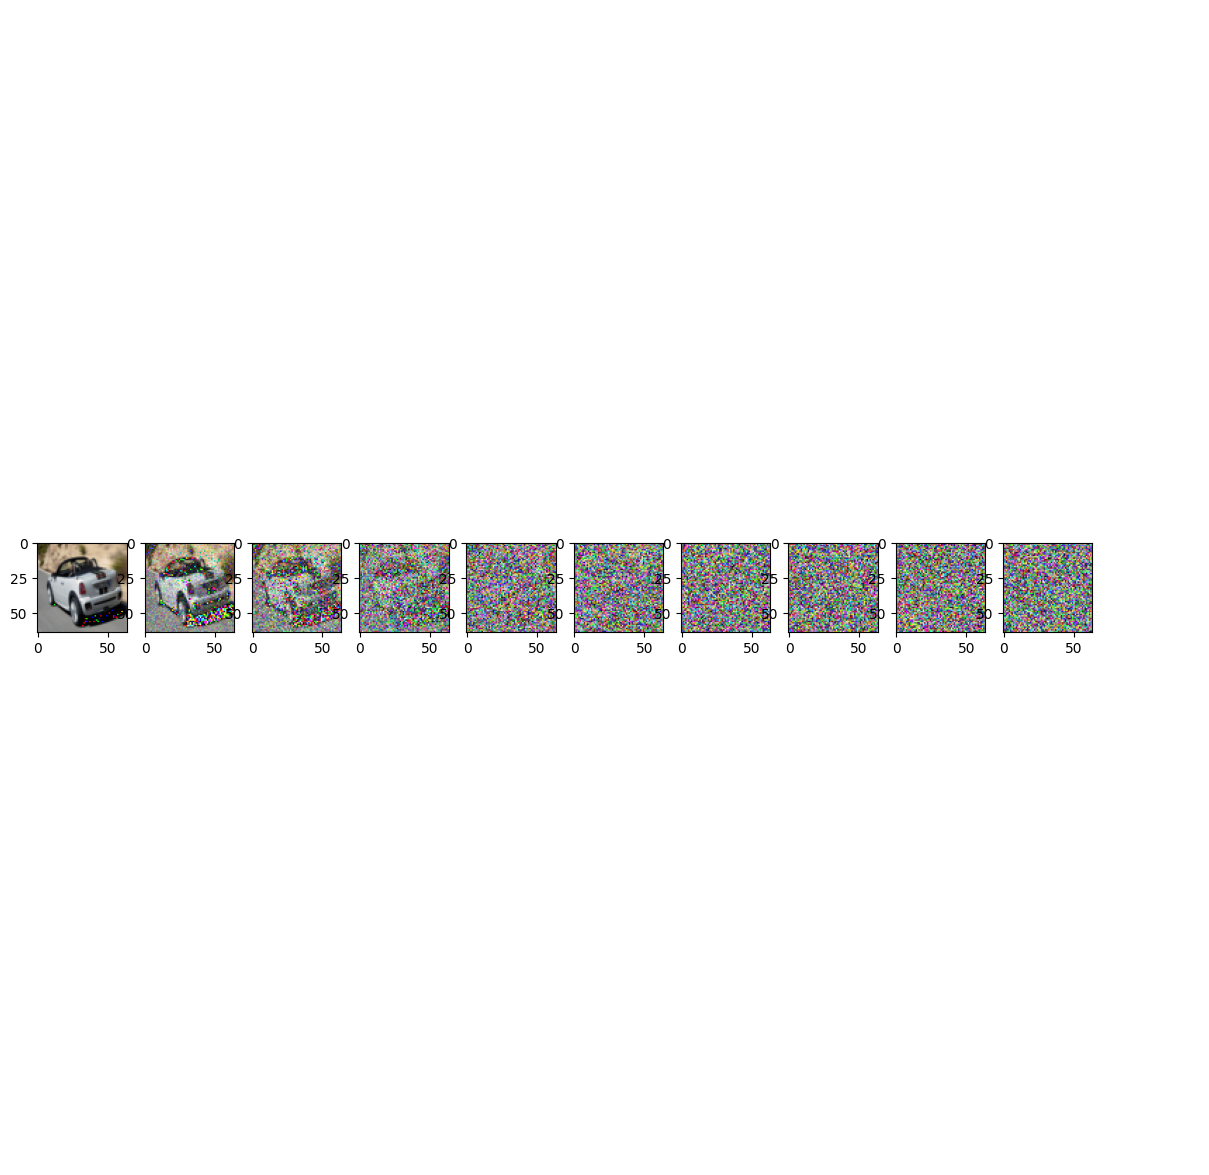

In [67]:
# Test forward pass

image = next (iter (data_loader))[0]

plt.figure (figsize = [15, 15])
plt.axis ("off")
num_images = 10
stepsize = int (T / num_images)

for id in range (0, T, stepsize):
    t = torch.Tensor ([id]).type (torch.int64)
    plt.subplot (1, num_images + 1, (int) (id / stepsize) + 1)
    img, noise = diffusion_forward (image, t)
    show_tensor_image (img)